In [1]:
import pandas as pd
import sys
import numpy as np
from pickle import dump,load
from collections import Counter
import torch 
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../')
%load_ext autoreload

In [71]:
df=pd.read_csv('../data/modified/data_to_work_on.csv')

In [8]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [37]:
%autoreload 2
from no_toxicity.src.preprocessing.cleaning import Dfcleaner

In [47]:
# Making the list of column to clean
raw_comments=df['comment_text'].to_list()

In [106]:
# See the cleaning.py to see how it works
cleaner=Dfcleaner()

In [22]:
cleaned_comments=cleaner.clean(raw_comments,stem=False)

10000 examples cleaned out of 159571
20000 examples cleaned out of 159571
30000 examples cleaned out of 159571
40000 examples cleaned out of 159571
50000 examples cleaned out of 159571
60000 examples cleaned out of 159571
70000 examples cleaned out of 159571
80000 examples cleaned out of 159571
90000 examples cleaned out of 159571
100000 examples cleaned out of 159571
110000 examples cleaned out of 159571
120000 examples cleaned out of 159571
130000 examples cleaned out of 159571
140000 examples cleaned out of 159571
150000 examples cleaned out of 159571
Cleaning Done


In [129]:
cleaned_comments=cleaner.remove_frequent_rare(cleaned_comments,frequent=True,rare=True)

10000 examples cleaned out of 159517
20000 examples cleaned out of 159517
30000 examples cleaned out of 159517
40000 examples cleaned out of 159517
50000 examples cleaned out of 159517
60000 examples cleaned out of 159517
70000 examples cleaned out of 159517
80000 examples cleaned out of 159517
90000 examples cleaned out of 159517
100000 examples cleaned out of 159517
110000 examples cleaned out of 159517
120000 examples cleaned out of 159517
130000 examples cleaned out of 159517
140000 examples cleaned out of 159517
150000 examples cleaned out of 159517
Cleaning Done


In [131]:
# Replacing the df column with new data
df['comment_text']=cleaned_comments

In [133]:
# # Saving the cleaned data (don't run this cell)
# df.to_csv('../data/interim/cleaned_data1.csv',index=False)

In [72]:
# Load the data
data=pd.read_csv('../data/interim/cleaned_data1.csv')
data.dropna(inplace=True)

In [73]:
# Let's make our own new feature
def new_col_value(row):
    flag=True
    # If the sample is toxic make it 0 and break else 1
    for i in row.iloc[1:]:
        if i==1:
            flag=False
            break
    if flag:
        return 1
    else:
        return 0


In [74]:
# Making the new feature
data['not_toxic']=data.apply(lambda row:new_col_value(row),axis=1)

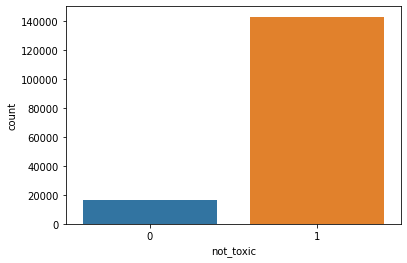

In [75]:
_=sns.countplot('not_toxic',data=data)

## We can clearly see our dataset is imbalanced so let's UnderSample our majority class

In [76]:
from imblearn.under_sampling import RandomUnderSampler

In [77]:
rus = RandomUnderSampler(random_state=42)
data,Y_label= rus.fit_resample(data.iloc[:,:-1],data.iloc[:,-1])
data['not_toxic']=Y_label

In [78]:
data = data.sample(frac=1).reset_index(drop=True)

In [79]:
data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,nonsense whether liberal group complain target...,0,0,0,0,0,0,1
1,case name past celebrity okay citation engage ...,0,0,0,0,0,0,1
2,suck asyou ignorant romanian nazi,1,0,1,0,1,1,0
3,stop continue blank delete portion content tem...,0,0,0,0,0,0,1
4,p fuck cunt piece shit hope die rot hell accus...,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
32445,full cunt,1,0,1,0,0,0,0
32446,also like point modwilson faux merely mean unt...,0,0,0,0,0,0,1
32447,yea well kiss fucker shit nut,1,0,1,0,1,0,0
32448,like know theoretical speed gigabit gibibit la...,0,0,0,0,0,0,1


In [80]:
%autoreload 2
from no_toxicity.src.preprocessing.preprocess import PrepareTheData

In [81]:
# See the preprocess.py to see how it works
dataset=PrepareTheData(data[['comment_text']],data.iloc[:,1:],max_vocab=4000)

Tokenization Done
Replacing Done
token2idx created
tokens_to_indices created
Presprocessing done


In [82]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [item[1] for item in batch]
    targets=torch.Tensor(targets)

    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(inputs, padding_value=dataset.token2idx_inputs[dataset.padding_token], batch_first=True)
 
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), targets[permutation].to(device), lengths.to(device)

# Define the Dataloaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate,shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=327, collate_fn=collate,shuffle=True)

In [85]:
%autoreload 2
from no_toxicity.src.models.MyModel import MyModel

In [86]:
model = MyModel(input_vocab_size=len(dataset.token2idx_inputs), 
            emd_dim=100, 
            hidden_size=300,
            batch_size=batch_size,
            n_layers=4, 
            token_to_idx=dataset.token2idx_inputs).to(device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [87]:
model.train()
i=0
for epoch in tqdm(range(100)):
    total_loss = total = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False,total=len(train_loader))
    for inputs, targets, lengths in progress_bar:
        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        loss,metric_ = model(inputs, targets, lengths)
        # print(inputs[:,-1])
        # Perform gradient descent, backwards pass
        # break
        loss.backward()

        # Take a step in the right direction
        optimizer.step()

        # Record metrics
        total_loss += loss
        total += targets.size(0)

    train_loss = total_loss / total
    if i%10==0:
        tqdm.write(f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tmodel_acc: {metric_}\n')
    i=i+1

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch #  1	train_loss: 1.39e-02	model_acc: {'accuracy': 0.72}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 11	train_loss: 1.39e-02	model_acc: {'accuracy': 0.54}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 21	train_loss: 1.39e-02	model_acc: {'accuracy': 0.5}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 31	train_loss: 1.39e-02	model_acc: {'accuracy': 0.62}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 41	train_loss: 1.39e-02	model_acc: {'accuracy': 0.52}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 51	train_loss: 1.39e-02	model_acc: {'accuracy': 0.38}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 61	train_loss: 1.39e-02	model_acc: {'accuracy': 0.5}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 71	train_loss: 1.39e-02	model_acc: {'accuracy': 0.42}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 81	train_loss: 1.39e-02	model_acc: {'accuracy': 0.52}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

epoch # 91	train_loss: 1.39e-02	model_acc: {'accuracy': 0.48}



Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/358 [00:00<?, ?it/s]

In [22]:
from no_toxicity.src.preprocessing.cleaning import Dfcleaner
def collate_pred(batch):
    pred_input=torch.LongTensor(batch)
    return pred_input.to(device)

def predict(raw_text):
    cleaner=Dfcleaner()
    cleaned_text=cleaner.clean(raw_text,stem=False,is_prediction=True)
    cleaned_text=cleaned_text[0]
    tokenized_text=dataset.tokenize(cleaned_text)
    encode = lambda x: [dataset.token2idx_inputs[token] for token in tokenized_text if token in dataset.token2idx_inputs]  
    encoded_text=encode(tokenized_text) 
    encoded_text=[encoded_text]
    test_loader = DataLoader(encoded_text, batch_size=1, collate_fn=collate_pred,shuffle=True)
    model.eval()
    with torch.no_grad():
        for inputs in test_loader:
            output=model.predict(inputs)
            
            print(output)
    

In [70]:
raw_text=["this a non toxic sentence"]
predict(raw_text)

['not_toxic']


In [93]:
raw_text=["This man is a retard"]
predict(raw_text)

['toxic', 'threat', 'insult']
